In [1]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns

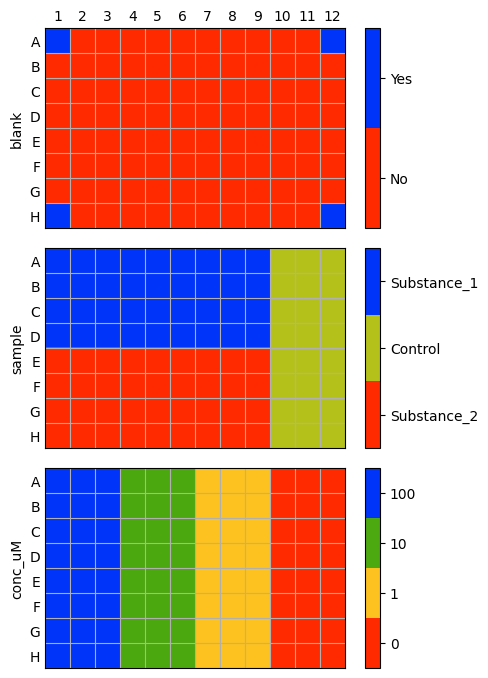

In [11]:
# wellmap.show("2 substance 1 plate.toml")
wellmap.show("RZ_screening.toml"); # Yes, this semicolon is meaningful. Or plates map will be duplicated

In [105]:
path_to_data = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-09 RD Slovesnova CK122 ISK1\MyExpt_Wells_plate.csv"

data_raw = pd.read_csv(path_to_data) 

print(data_raw.columns)
# print(data)


Index(['ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed'],
      dtype='object')


In [106]:
data = data_raw[['Intensity_IntegratedIntensity_OrigGreen','Intensity_IntegratedIntensity_OrigRed','Intensity_MeanIntensity_OrigGreen','Intensity_MeanIntensity_OrigRed']].copy()
print(data)

    Intensity_IntegratedIntensity_OrigGreen  \
0                                193.192162   
1                                422.733343   
2                                367.172560   
3                                453.905894   
4                                123.219612   
..                                      ...   
91                              1569.239256   
92                              1660.870632   
93                              1718.729456   
94                              1863.094167   
95                               173.725495   

    Intensity_IntegratedIntensity_OrigRed  Intensity_MeanIntensity_OrigGreen  \
0                             1580.349057                           0.035403   
1                             1525.886316                           0.077466   
2                             1695.988277                           0.067285   
3                             1759.968670                           0.083179   
4                             1865.

In [107]:
row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))

row_column_list = []

for c in column:
    for r in row:
        array_i = [r,c]
        row_column_list.append(array_i)


# print(row_column_list)


row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

   row  col
0    A    1
1    B    1
2    C    1
3    D    1
4    E    1
..  ..  ...
91   D   12
92   E   12
93   F   12
94   G   12
95   H   12

[96 rows x 2 columns]


In [108]:

data_indexed = pd.concat([row_column_df, data], axis=1, join='inner')


data_indexed['col']=data_indexed['col'].astype(str)
print(data_indexed)

   row col  Intensity_IntegratedIntensity_OrigGreen  \
0    A   1                               193.192162   
1    B   1                               422.733343   
2    C   1                               367.172560   
3    D   1                               453.905894   
4    E   1                               123.219612   
..  ..  ..                                      ...   
91   D  12                              1569.239256   
92   E  12                              1660.870632   
93   F  12                              1718.729456   
94   G  12                              1863.094167   
95   H  12                               173.725495   

    Intensity_IntegratedIntensity_OrigRed  Intensity_MeanIntensity_OrigGreen  \
0                             1580.349057                           0.035403   
1                             1525.886316                           0.077466   
2                             1695.988277                           0.067285   
3                  

In [109]:
labels = wellmap.load('RZ_screening.toml')
# print(labels.dtypes)
# print(data_indexed.dtypes)


data_plate = pd.merge(data_indexed, labels)
print(labels)

   well well0 row col  row_i  col_j blank       sample conc_uM
0    A1   A01   A   1      0      0   Yes  Substance_1     100
1    H1   H01   H   1      7      0   Yes  Substance_2     100
2   A12   A12   A  12      0     11   Yes      Control       0
3   H12   H12   H  12      7     11   Yes      Control       0
4    A2   A02   A   2      0      1    No  Substance_1     100
..  ...   ...  ..  ..    ...    ...   ...          ...     ...
91  G10   G10   G  10      6      9    No      Control       0
92  G11   G11   G  11      6     10    No      Control       0
93  G12   G12   G  12      6     11    No      Control       0
94  H10   H10   H  10      7      9    No      Control       0
95  H11   H11   H  11      7     10    No      Control       0

[96 rows x 9 columns]


Cleaning


In [110]:
blank_green = data_plate[(data_plate['blank'] == 'Yes')].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
control_green = data_plate[(data_plate['sample'] == 'Control')].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

data_plate_wo_blank = data_plate[data_plate.blank == 'No'].copy()

data_plate_wo_blank['Green'] = data_plate_wo_blank['Intensity_MeanIntensity_OrigGreen'] - blank_green


data_plate_wo_blank['Green_relative'] = data_plate_wo_blank['Green']/control_green



Drop outliers

In [114]:
well_drop_list = ['H4','H5','H6','G4','G5']

data_plate_wo_blank = data_plate_wo_blank[~data_plate_wo_blank['well'].isin(well_drop_list)]

df_show = data_plate_wo_blank.loc[(data_plate_wo_blank['sample'] == 'Substance_1') & (data_plate_wo_blank['conc_uM'] == '100')]

print(df_show[['Green_relative','well']])


    Green_relative well
1         0.160628   B1
8         0.099118   A2
10        0.069768   C2
11        0.089928   D2
16        0.140389   A3
17        0.079662   B3
18        0.092048   C3


Plotting


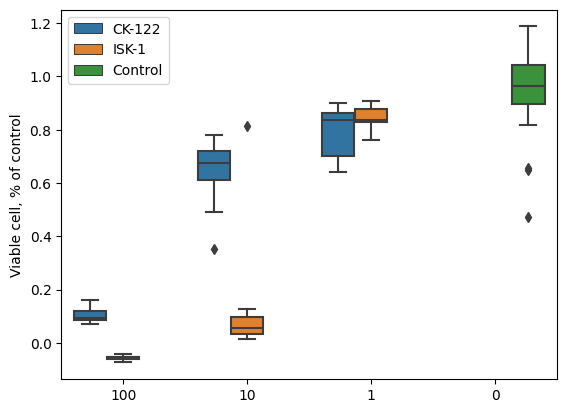

In [116]:
# sns.swarmplot(data=data_plate_wo_blank, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", hue='sample')
ax = sns.boxplot(data=data_plate_wo_blank, x="conc_uM", y="Green_relative", hue='sample')\

ax.set(xlabel=None, ylabel='Viable cell, % of control')


handles, labels = ax.get_legend_handles_labels()
labels = ['CK-122','ISK-1','Control']
ax.legend(handles=handles, labels=labels)